# K-Means Clustering: From Intuition to Implementation

Welcome!  

You'll learn:
1. What clustering and *unsupervised learning* are  
2. The K-Means algorithm (step by step, visually and mathematically)  
3. How to implement K-Means **from scratch**  
4. How to use `sklearn.cluster.KMeans`  
5. How to choose `K` using the **Elbow method**  
6. K-Means strengths, limitations, and real-world use cases  
7. A quick look at alternatives (Gaussian Mixture Models, DBSCAN, etc.)

---

We'll work with:
- A **toy synthetic dataset** (blobs in 2D) for intuition and plots  
- A **real dataset (Iris)** to see how K-Means behaves on real measurements

Let's begin ✨


## 1. What is Unsupervised Learning?

In supervised learning:
- We train a model using labeled examples.
- Example: classify an image as `cat` or `dog`, where each image has a known label.

In unsupervised learning:
- We are *not* given labels.
- The algorithm just sees raw data and tries to **discover structure** in it.

Think of it like:
> "Here's a pile of socks from the laundry. Please group similar socks together — but I won't tell you which belong together."

### Clustering
Clustering is a type of unsupervised learning where the goal is:
- Group similar points together  
- Such that points in the same group are "close" to each other  
- And points in different groups are "far apart"

We’ll focus on **K-Means**, one of the most widely used clustering algorithms in practice.


## 2. K-Means Intuition

### What does "K-Means" mean?
- **K** = number of clusters we want the algorithm to find  
- **Means** = each cluster is represented by the *mean* (average) position of the points assigned to it  
  - That average is called the **centroid**

### High-level idea:
We want to place `K` centroids in the data such that:
- Every data point is assigned to its *closest* centroid
- Points assigned to the same centroid form a **cluster**
- Centroids are updated to be the average of their assigned points
- Repeat until things stop changing

This is essentially:
> "Find good meeting points so that everyone goes to their nearest meeting point, and then move each meeting point to the average of its attendees."


## 3. K-Means Algorithm (Step-by-Step)

We'll describe the iterative loop.

**Input:**
- Data points: \\( X = \{x_1, x_2, \dots, x_n\} \\)
- Desired number of clusters: \\( K \\)

**Output:**
- Cluster assignments for each point
- Centroid locations \\( \mu_1, \mu_2, \dots, \mu_K \\)

---

### Step 0: Initialize centroids
Pick `K` initial centroids. (Often random points from the dataset.)

### Step 1: Assignment step
For each point, assign it to the closest centroid (using a distance metric, usually Euclidean distance).

Formally, point \\( x_j \\) goes to cluster \\( C_i \\) where:

\\[
i = \arg\min_{c \in \{1, \dots, K\}} \lVert x_j - \mu_c \rVert^2
\\]

### Step 2: Update step
For each cluster, recompute its centroid as the mean of all points assigned to it:

\\[
\mu_i = \frac{1}{|C_i|} \sum_{x_j \in C_i} x_j
\\]

### Step 3: Repeat
Alternate **Assignment → Update → Assignment → ...**  
until the centroids stop moving (or move very little), or we hit a max number of iterations.

> Each iteration **never makes things worse**: it always reduces (or keeps the same) the total within-cluster squared distance.


## 4. The Optimization View (Why K-Means Works)

K-Means tries to minimize the *inertia*, also known as **within-cluster sum of squared distances**:

\\[
J = \sum_{i=1}^{K} \sum_{x_j \in C_i} \| x_j - \mu_i \|^2
\\]

Interpretation:
- For each cluster \\( C_i \\), we measure how far each point is from its centroid \\( \mu_i \\)
- We square and sum those distances
- We add that up across all clusters
- We want that total to be **as small as possible**

Why the two steps make sense:
- **Assignment step** chooses for each point the closest centroid → directly lowers \\( J \\)
- **Update step** recomputes each centroid as the mean → the mean is the point that *minimizes squared distance* to all points in that cluster

So the algorithm is basically alternating between two partial optimizations of the same objective.


## 5. Setup

Let's import the libraries we will use.

We'll need:
- `numpy` for numerical operations
- `matplotlib` for visualization
- `sklearn.datasets` to generate or load datasets
- Our own `KMeans` class (we'll reimplement below, inspired by your `Model.py`)
- `sklearn.cluster.KMeans` to compare with a standard library implementation


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported.")

Libraries imported.


## 6. Implementing K-Means From Scratch (No scikit-learn)

Below is a clean, well-commented implementation of K-Means inspired by your provided `Model.py`.

We'll implement:
- centroid initialization
- distance computation
- assignment
- centroid update
- stopping condition
- inertia calculation (the objective value)


In [3]:
class KMeansScratch:
    """
    A minimal K-Means implementation.

    Parameters
    ----------
    n_clusters : int
        Number of clusters (K).
    max_iter : int
        Maximum number of iterations for the update loop.
    random_state : int or None
        Random seed for reproducibility.

    Attributes
    ----------
    centroids : array of shape (K, n_features)
        Cluster centroids.
    labels_ : array of shape (n_samples,)
        Cluster assignment for each point.
    inertia_ : float
        Sum of squared distances of samples to their closest centroid.
    """
    def __init__(self, n_clusters=2, max_iter=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def _initialize_centroids(self, X):
        """Pick K random points from X as initial centroids."""
        if self.random_state is not None:
            np.random.seed(self.random_state)
        indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        self.centroids = X[indices]

    def _compute_distances(self, X):
        """Return distance matrix of shape (n_clusters, n_samples).

        distances[i, j] = Euclidean distance between centroid i and point j.
        """
        # broadcasting trick:
        # X has shape (n_samples, n_features)
        # self.centroids has shape (K, n_features)
        # We want pairwise distances
        diff = X[None, :, :] - self.centroids[:, None, :]  # shape (K, n_samples, n_features)
        distances = np.sqrt(np.sum(diff ** 2, axis=2))     # shape (K, n_samples)
        return distances

    def _assign_clusters(self, distances):
        """Assign each point to the nearest centroid index."""
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        """Recompute each centroid as the mean of its assigned points."""
        new_centroids = []
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            # In rare edge cases, a cluster may get zero points.
            # We'll keep the previous centroid if that happens.
            if len(cluster_points) == 0:
                new_centroids.append(self.centroids[k])
            else:
                new_centroids.append(cluster_points.mean(axis=0))
        self.centroids = np.vstack(new_centroids)

    def _compute_inertia(self, X, labels):
        """Compute total within-cluster sum of squared distances."""
        inertia = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) == 0:
                continue
            diff = cluster_points - self.centroids[k]
            inertia += np.sum(diff ** 2)
        return inertia

    def fit(self, X):
        """Run the K-Means algorithm on data X."""
        self._initialize_centroids(X)

        for _ in range(self.max_iter):
            old_centroids = self.centroids.copy()

            # Step 1: assign
            distances = self._compute_distances(X)
            self.labels_ = self._assign_clusters(distances)

            # Step 2: update
            self._update_centroids(X, self.labels_)

            # Track inertia
            self.inertia_ = self._compute_inertia(X, self.labels_)

            # Stopping condition: if centroids didn't move, we're done
            if np.allclose(old_centroids, self.centroids):
                break

        return self

    def predict(self, X):
        """Assign new points to the nearest learned centroid."""
        diff = X[None, :, :] - self.centroids[:, None, :]
        distances = np.sqrt(np.sum(diff ** 2, axis=2))
        return np.argmin(distances, axis=0)

    def fit_predict(self, X):
        """Convenience method: fit, then return labels."""
        self.fit(X)
        return self.labels_


print("KMeansScratch class defined.")

KMeansScratch class defined.


## 7. Visualizing K-Means on a Synthetic Dataset

We'll generate a simple 2D dataset with clearly separated clusters using `make_blobs`.

Then we'll:
1. Run our `KMeansScratch`
2. Plot the assigned clusters
3. Plot the learned centroids


In [41]:
# Generate synthetic data (3 blobs in 2D)
X_blobs, y_true = make_blobs(
    n_samples=400,
    centers=3,
    cluster_std=1.2,
    n_features=2,
    random_state=RANDOM_STATE
)

# Fit our scratch implementation
kmeans_scratch = KMeansScratch(n_clusters=3, max_iter=100, random_state=RANDOM_STATE)
labels_scratch = kmeans_scratch.fit_predict(X_blobs)

print('Final centroids from scratch implementation:')
print(kmeans_scratch.centroids)
print('Inertia:', kmeans_scratch.inertia_)

Final centroids from scratch implementation:
[[ 4.67841426  1.89528916]
 [-2.60358976  9.05708183]
 [-6.92405782 -6.82615426]]
Inertia: 1108.1267371175331


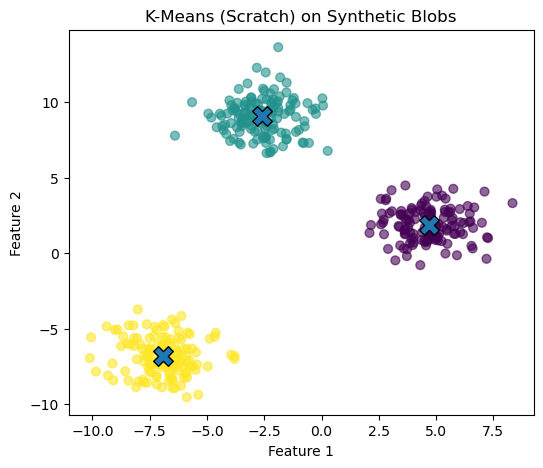

In [40]:
# Let's visualize the clusters

plt.figure(figsize=(6,5))

# Scatter plot of data, colored by cluster assignment
plt.scatter(
    X_blobs[:, 0],
    X_blobs[:, 1],
    c=labels_scratch,
    alpha=0.6,
    s=40
)

# Plot centroids
plt.scatter(
    kmeans_scratch.centroids[:, 0],
    kmeans_scratch.centroids[:, 1],
    marker='X',
    s=200,
    edgecolor='black'
)

plt.title('K-Means (Scratch) on Synthetic Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## 8. Comparing With `sklearn.cluster.KMeans`

Now let's run scikit-learn's `KMeans` on the *same* data and confirm we get similar centroids / assignments.

Note: scikit-learn has:
- smarter initialization (`k-means++` by default), which usually improves stability
- more checks and options


In [6]:
sk_kmeans = SklearnKMeans(
    n_clusters=3,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=RANDOM_STATE
)

sk_labels = sk_kmeans.fit_predict(X_blobs)

print('sklearn centroids:')
print(sk_kmeans.cluster_centers_)
print('sklearn inertia:', sk_kmeans.inertia_)

sklearn centroids:
[[-2.60358976  9.05708183]
 [-6.92405782 -6.82615426]
 [ 4.67841426  1.89528916]]
sklearn inertia: 1108.1267371175331


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


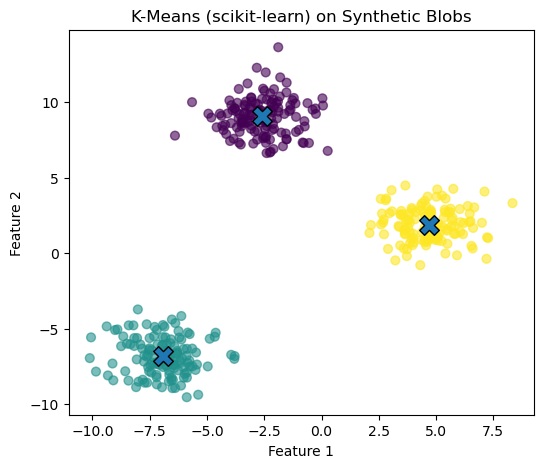

In [30]:
# Visualize sklearn result

plt.figure(figsize=(6,5))

plt.scatter(
    X_blobs[:, 0],
    X_blobs[:, 1],
    c=sk_labels,
    alpha=0.6,
    s=40
)

plt.scatter(
    sk_kmeans.cluster_centers_[:, 0],
    sk_kmeans.cluster_centers_[:, 1],
    marker='X',
    s=200,
    edgecolor='black'
)

plt.title('K-Means (scikit-learn) on Synthetic Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## 9. How Do We Choose K? The Elbow Method

K-Means requires us to *choose K*, the number of clusters.

But how?

A common heuristic is the **Elbow Method**:

1. Run K-Means for different values of K (e.g. 1, 2, 3, ..., 10)
2. Record the inertia (within-cluster sum of squares)
3. Plot K vs inertia
4. Look for the "elbow": a point where adding more clusters doesn't improve things very much anymore.

The elbow is where the gain in clustering quality starts to slow down.


In [19]:
# --- Windows + scikit-learn KMeans warning note ---
# On some Windows setups with MKL, scikit-learn's KMeans shows a warning
# about a possible memory leak. Limiting the number of threads avoids it.
import os, warnings
os.environ["OMP_NUM_THREADS"] = "2"

warnings.filterwarnings(
    "ignore",
    message="KMeans is known to have a memory leak on Windows with MKL"
)

# Now import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment ready. Libraries imported.")


Environment ready. Libraries imported.


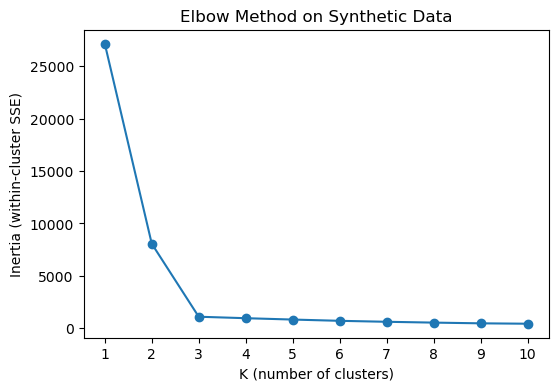

In [20]:
inertias = []
K_values = list(range(1, 11))
for K in K_values:
        model = SklearnKMeans(
            n_clusters=K,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=RANDOM_STATE,
        )
        model.fit(X_blobs)
        inertias.append(model.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_values, inertias, marker='o')
plt.xticks(K_values)
plt.xlabel('K (number of clusters)')
plt.ylabel('Inertia (within-cluster SSE)')
plt.title('Elbow Method on Synthetic Data')
plt.show()

## 10. K-Means on a Real Dataset: Iris 🌸

The Iris dataset is a classic dataset in machine learning:
- 150 samples of flowers
- 3 species (Setosa, Versicolor, Virginica)
- Each sample has 4 numeric features:
  - sepal length
  - sepal width
  - petal length
  - petal width

Important:
- The species labels are known to us (for evaluation),  
  BUT K-Means will *not* use them.
  It will try to find 3 clusters based only on the feature values.


In [21]:
iris = load_iris()
X_iris = iris['data']          # shape (150,4)
y_iris = iris['target']        # ground-truth labels 0,1,2 (for reference)

print('Iris shape:', X_iris.shape)
print('Feature names:', iris['feature_names'])

Iris shape: (150, 4)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Why scaling?

K-Means uses Euclidean distance.  
If one feature has a much larger numeric range than the others, it will dominate the distance.

So it's common to **standardize** features (zero mean, unit variance).


In [22]:
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

print("First 5 rows (scaled):")
print(X_iris_scaled[:5])

First 5 rows (scaled):
[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]]


### Fit K-Means on Iris

We'll ask for `K=3` clusters and see how well that lines up with the 3 species.
We'll *not* expect perfection — K-Means is not using the true species labels.


In [23]:
iris_kmeans = SklearnKMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    max_iter=300,
    random_state=RANDOM_STATE
)
iris_labels = iris_kmeans.fit_predict(X_iris_scaled)

print('Cluster centroids in scaled feature space:')
print(iris_kmeans.cluster_centers_)
print('Inertia on Iris:', iris_kmeans.inertia_)

Cluster centroids in scaled feature space:
[[-0.05021989 -0.88337647  0.34773781  0.2815273 ]
 [-1.01457897  0.85326268 -1.30498732 -1.25489349]
 [ 1.13597027  0.08842168  0.99615451  1.01752612]]
Inertia on Iris: 139.82049635974982


### Visualizing Iris Clusters (PCA 2D Projection)

While the Iris dataset has 4 features, visualizing in 4D isn't easy.  
To see the clustering structure, we can use **Principal Component Analysis (PCA)** to project the data down to 2 dimensions.

PCA finds the directions (linear combinations of features) that explain the most variance in the data.  
This gives us a 2D representation that captures most of the information from all 4 features.

We'll plot:
- Each flower as one point
- Color = the predicted K-Means cluster ID


In [24]:
from sklearn.decomposition import PCA

# We already had:
# X_iris          -> original features (150, 4)
# X_iris_scaled   -> standardized features (150, 4)
# iris_labels     -> K-Means predicted clusters (0,1,2)
# y_iris          -> true species labels (0,1,2)

# Reduce to 2 principal components
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_iris_pca = pca.fit_transform(X_iris_scaled)

print("PCA shape:", X_iris_pca.shape)  # should be (150, 2)
print("Explained variance ratio:", pca.explained_variance_ratio_)


PCA shape: (150, 2)
Explained variance ratio: [0.72962445 0.22850762]


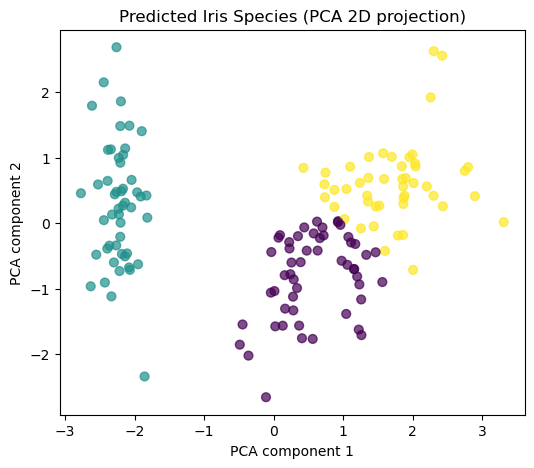

In [43]:
plt.figure(figsize=(6,5))

plt.scatter(
    X_iris_pca[:, 0],
    X_iris_pca[:, 1],
    c=iris_labels,    # ground-truth species
    alpha=0.7,
    s=40
)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('Predicted Iris Species (PCA 2D projection)')
plt.show()


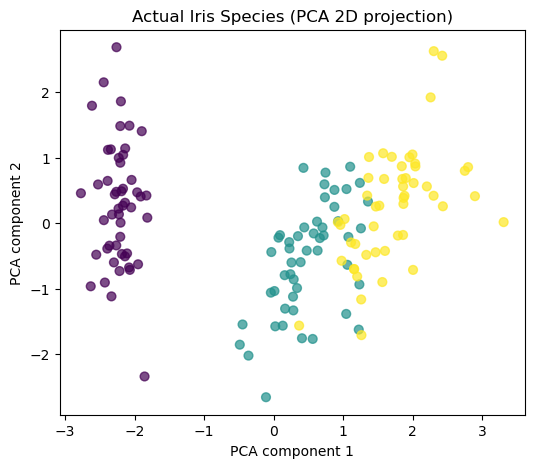

In [44]:
plt.figure(figsize=(6,5))

plt.scatter(
    X_iris_pca[:, 0],
    X_iris_pca[:, 1],
    c=y_iris,    # ground-truth species
    alpha=0.7,
    s=40
)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('Actual Iris Species (PCA 2D projection)')
plt.show()


### How good are the clusters?

We *can* compare K-Means' predicted labels to the true species labels,  
but you have to be careful:

- Cluster IDs (0,1,2) are **arbitrary**.  
  Cluster "0" might correspond to the species Virginica, etc.
- So you can't just do raw accuracy without first matching clusters to species.

Typical unsupervised evaluation metrics:
- **Adjusted Rand Index (ARI)**
- **Normalized Mutual Information (NMI)**
- **Silhouette score** (measures cluster separation)

We'll compute ARI and NMI to get a feel.


In [27]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_iris, iris_labels)
nmi = normalized_mutual_info_score(y_iris, iris_labels)

print('Adjusted Rand Index (ARI):', ari)
print('Normalized Mutual Information (NMI):', nmi)

Adjusted Rand Index (ARI): 0.6201351808870379
Normalized Mutual Information (NMI): 0.659486892724918


## 11. Strengths and Limitations of K-Means

### ✅ Strengths
- **Simple and intuitive** (easy to explain to non-ML people)
- **Fast and scalable** (works well even with large datasets)
- **Works nicely for well-separated, roughly spherical clusters**

### ⚠ Limitations
1. **You must choose K in advance**
   - The algorithm doesn't tell you the "right" number of clusters.
   - You need heuristics like the Elbow method or domain knowledge.

2. **Sensitive to initialization**
   - Different random initial centroids can give different results.
   - `k-means++` is a smarter initialization strategy that helps.

3. **Assumes roughly spherical / convex clusters**
   - K-Means draws Voronoi-style boundaries.
   - It struggles when clusters are not blob-shaped.
   - Bad for concentric rings, spirals, etc.

4. **Sensitive to outliers**
   - A single extreme point can pull a centroid far away from where it "should" be,
     because the mean is not robust.

> Bottom line: K-Means is amazing when its assumptions match your data structure,
> and misleading when they don't.


## 12. Alternatives to K-Means

### 1. Gaussian Mixture Models (GMM)
- Instead of "hard" assignments (each point in exactly one cluster),
  GMM gives **soft probabilities** for each cluster.
- Clusters can have different shapes (elliptical covariance), not just spheres.
- Trained using the **Expectation-Maximization (EM)** algorithm.
- You already have a `GaussianMixtureModel` implementation in your codebase.

### 2. DBSCAN
- Density-based clustering.
- Does **not** require specifying K.
- Can find arbitrarily-shaped clusters.
- Can mark outliers as "noise".

### 3. Hierarchical Clustering
- Builds a hierarchy (tree / dendrogram).
- You can "cut" the tree at different levels to choose number of clusters.
- Useful for interpretability.

---

So in practice:
- Try K-Means first (fast, baseline).
- If shapes are weird (non-convex), try DBSCAN.
- If you think clusters have different covariance shapes, try GMM.


## 13. Recap / Checklist

You should now understand:

- ✅ What unsupervised learning is  
- ✅ What clustering is and why we use it  
- ✅ The K-Means algorithm (init → assign → update → repeat)  
- ✅ The K-Means objective function (inertia / WCSS)  
- ✅ How to implement K-Means from scratch in NumPy  
- ✅ How to run and visualize K-Means on synthetic and real datasets  
- ✅ How to choose K using the Elbow method  
- ✅ When K-Means is a good idea — and when it's not  
- ✅ A few alternative clustering methods (GMM, DBSCAN, Hierarchical)

You’re in great shape to:
- use K-Means in real data analysis,
- explain it in an interview,
- and modify it for research / homework.

🎉 Great work!
